In [105]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
def melted_author_list(scopus_dataframe):
    author_list = []
    new_list = []
    melted_authors = []
    
    for i in scopus_dataframe['Authors']:
        com_replace = i.split('., ')
        author_list.append(com_replace)

    for i in author_list:
        new_i = i
        for j in i:
            if j.endswith('.'):
                new_i.remove(j)
            new_list.append(new_i)
            
    for lists in new_list:
        for author in lists:
            if author not in melted_authors:
                melted_authors.append(author)
    return melted_authors,new_list

def node_collect(names_of_authors,new_list):
    node_collector = {}
    counter = 0
    for author in names_of_authors:
        value = []
        for i in new_list:
            if author in i:
                for node_author in i:
                    if node_author not in value:
                        value.append(node_author)
        node_collector[author] = value
        counter += 1
        if not (counter%1000):
            print(f'{counter} authors processed')
    return(node_collector)

def edge_collect(nodes_dict):
    edge_collector = []
    for node_value,edges in nodes_dict.items():
        for actual_edge in edges:
            if actual_edge!=node_value:
                out = (node_value,actual_edge)
                edge_collector.append(out)   
    return edge_collector

def network_graph(nodes,edges):
    G = nx.Graph() 
    G.clear()
    for i in nodes.keys():
        G.add_node(i)
    G.add_edges_from(edges)
    print(f'nodes: {G.number_of_nodes()}\nedges: {G.number_of_edges()}')
    return G

In [100]:
#path = 'path/to/csv'
#year = [start_year,end_year]
#threshold = top number of authors to create network plot 
#label = All Labels (default False)
#label_no = number of top nodes to be labels (default 10)
def run_network_analysis(path,year = [0,2020],threshold = 10, label = False, label_no = 10):
    labels = {}
    print ('increasing the delta of years exponentially increases computation load')
    data_used = pd.read_csv(path)    
    data_used = data_used[data_used['Year'] < year[1]]
    data_used = data_used[data_used['Year'] > year[0]]
    print (f'{data_used.shape[0]}: Articles from year {year[0]} to {year[1]} identified')
    print (f'Threshold range: 0 - {data_used.shape[0]}\nrecommended range 20-50')
    melted_authors,new_list = melted_author_list(data_used)
    node_collector = node_collect(melted_authors,new_list)
    author_affil = {}
    for i in node_collector.keys():
        author_affil[i] = len(node_collector[i])
    author_affil = pd.DataFrame.from_dict(author_affil,orient = 'index').reset_index().rename(columns = {'index':'author',0:'affiliated_authors'}).sort_values(by='affiliated_authors',ascending=True)    
    selector = author_affil.sort_values(by='affiliated_authors',ascending=False).head(threshold)['author']
    selector_val = author_affil.sort_values(by='affiliated_authors',ascending=False).head(threshold)['affiliated_authors']
    nodes = node_collect(selector,new_list)
    edges = edge_collect(nodes)
    for label in author_affil.sort_values(by = 'affiliated_authors',ascending = False).head(label_no)['author']:
        labels[label] = label
    G = network_graph(nodes,edges)
    d = nx.degree(G)
    d = [(d[node]+1) * 20 for node in G.nodes()]
    plt.figure(figsize = (30,15))
    plt.figtext(.5,.9,f'Network plot {year} G6PD', fontsize=50, ha='center')
    nx.draw(G, node_size = [size for size in d],labels = labels)
    plt.savefig('/Users/tim/Desktop/plt.pdf')
    return author_affil

increasing the delta of years exponentially increases computation load
2850: Articles from year 1991 to 2015 identified
Threshold range: 0 - 2850
recommended range 20-50
1000 authors processed
2000 authors processed
3000 authors processed
4000 authors processed
5000 authors processed
6000 authors processed
7000 authors processed
8000 authors processed
nodes: 492
edges: 3298


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


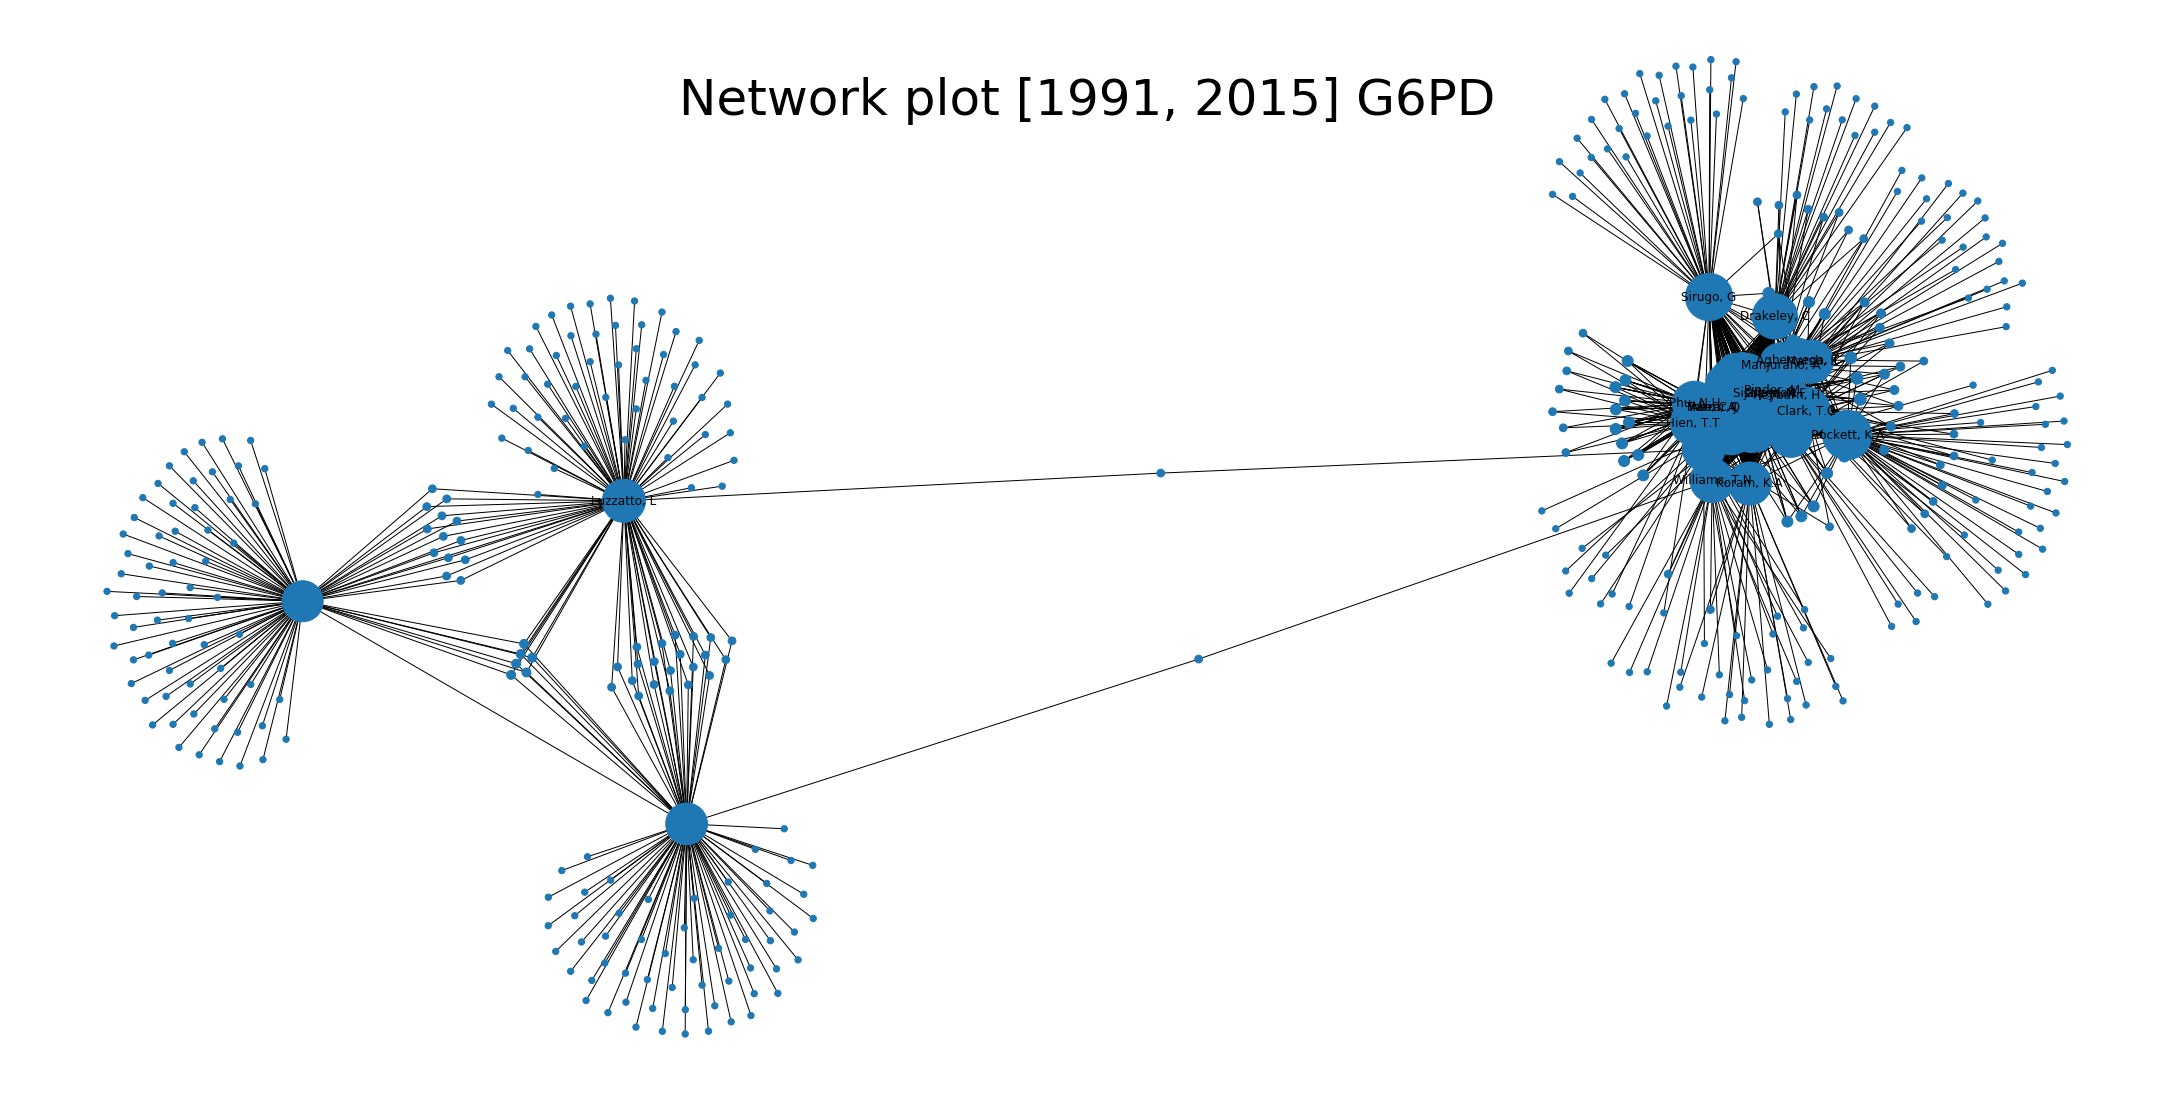

In [101]:
author_affil = run_network_analysis('/Users/tim/Desktop/scopus.csv',year = [1991 , 2015], threshold = 50, label_no = 20, label = False)